In [1]:
# install.packages("GGally")
# install.packages("janitor")

In [2]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(funModeling) 
library(Hmisc)
library(GGally)
library(car)
library(janitor)
library(scales)

### 2. Exploratory Data Analysis

#### 2.0 Data Pre-process
**Data downloaded from web into R**

In [45]:
data<- read.csv("https://raw.githubusercontent.com/Zibo-S/STAT301_GP_4/main/insurance.csv", header= TRUE)

**Check to make sure data is in a tidy format**

In [46]:
data%>%head(3)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.90,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.552
3,28,male,33.00,3,no,southeast,4449.462


As we can see, our data set is in a tidy format.

**Check if there is any missing value in data set.**

In [47]:
lapply(data,length)

$age
[1] 1338

$sex
[1] 1338

$bmi
[1] 1338

$children
[1] 1338

$smoker
[1] 1338

$region
[1] 1338

$charges
[1] 1338

As we can see, there is no missing value in our data set. <br>
Then, continuous to EDA

#### 2.1 Exploratory Data Analysis 
**Split variables into categorical and numerical, then check their unique values.**

In [48]:
data%>%summary()

      age            sex                 bmi           children    
 Min.   :18.00   Length:1338        Min.   :15.96   Min.   :0.000  
 1st Qu.:27.00   Class :character   1st Qu.:26.30   1st Qu.:0.000  
 Median :39.00   Mode  :character   Median :30.40   Median :1.000  
 Mean   :39.21                      Mean   :30.66   Mean   :1.095  
 3rd Qu.:51.00                      3rd Qu.:34.69   3rd Qu.:2.000  
 Max.   :64.00                      Max.   :53.13   Max.   :5.000  
    smoker             region             charges     
 Length:1338        Length:1338        Min.   : 1122  
 Class :character   Class :character   1st Qu.: 4740  
 Mode  :character   Mode  :character   Median : 9382  
                                       Mean   :13270  
                                       3rd Qu.:16640  
                                       Max.   :63770  

<p style="text-align: center;"> *Table $2.1.0$ Data Set Summary*

In [49]:
data_unique<- data%>% status()%>% select (unique)
data_unique

,unique
,<int>
age,47
sex,2
bmi,548
children,6
smoker,2
region,4
charges,1337


<p style="text-align: center;">  *Table $2.1.1$ Variable Unique Values*

As we can see variable children only has 6 values, so it should be considered as a categorical variable. <br>
**Categorical Variables:** "sex", "children", "smoker", "region"<br>
**Numerical Variables:** "age", "bmi", "charges"<br>

Here we split the data into training set (70 $\%$) and testing set (30$\%$)

In [50]:
set.seed(1234)

data$ID <- 1:nrow(data)
training_set <- sample_n(data, size = nrow(data) * 0.70,
  replace = FALSE
)

testing_set <- anti_join(data,
  training_set,
  by = "ID"
)

head(training_set, 3)
nrow(training_set)

head(testing_set, 3)
nrow(testing_set)

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,32,male,28.12,4,yes,northwest,21472.479,1308
2,26,female,34.20,2,no,southwest,3987.926,1018
3,23,female,42.75,1,yes,northeast,40904.200,1125


[1] 936

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,28,male,33.00,3,no,southeast,4449.462,3
2,32,male,28.88,0,no,northwest,3866.855,5
3,37,female,27.74,3,no,northwest,7281.506,8


[1] 402

**Check data balancing for our target variable Charges by histogram.** 

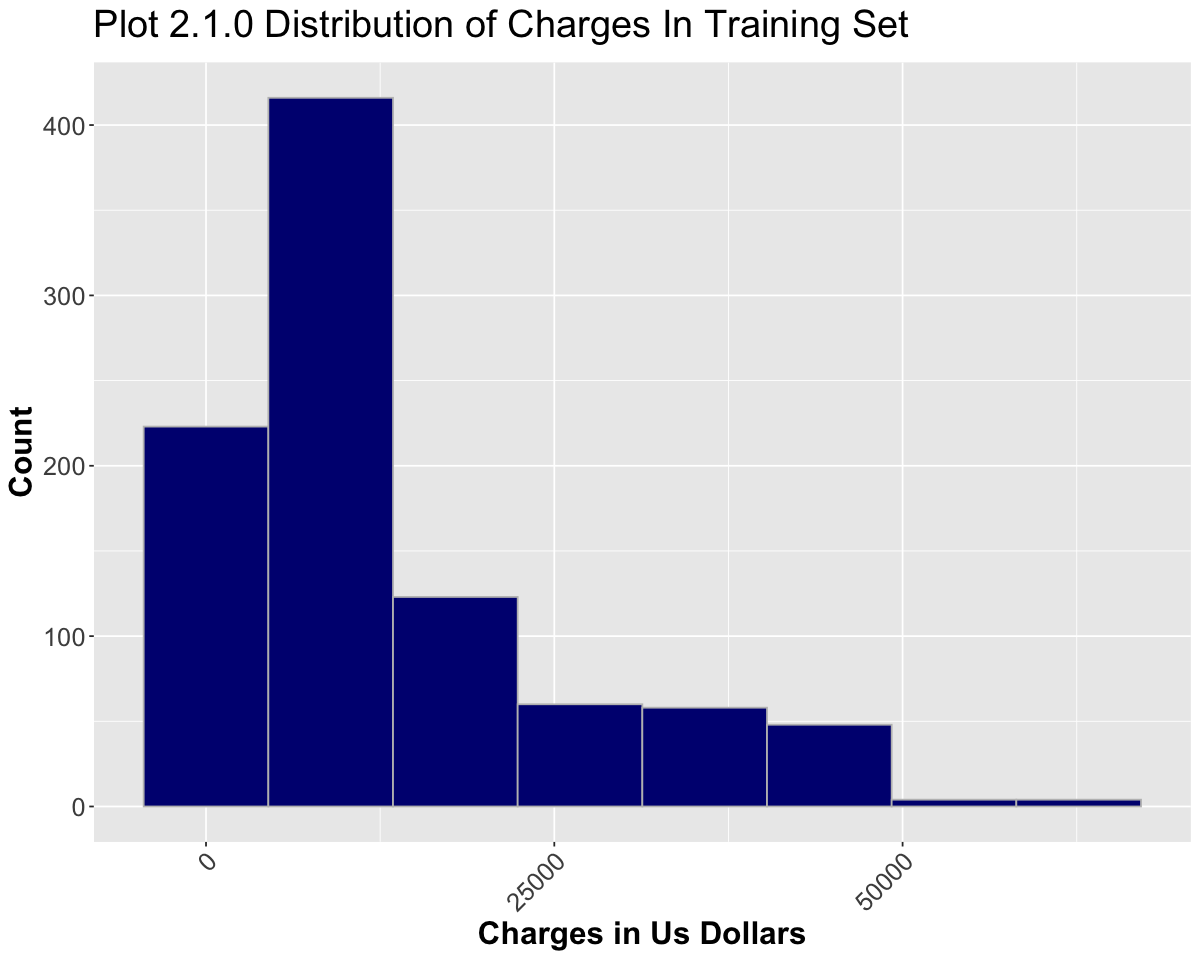

In [78]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_charges <- ggplot(training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  ggtitle(expression("Plot 2.1.0 Distribution of Charges In Training Set"))
hist_charges

As we can see, there are less count for chargers over $25000, which make sense, since less people are being charged for higher amount. <br>

**Explore the association of the numerical explanatory variables with the target.**

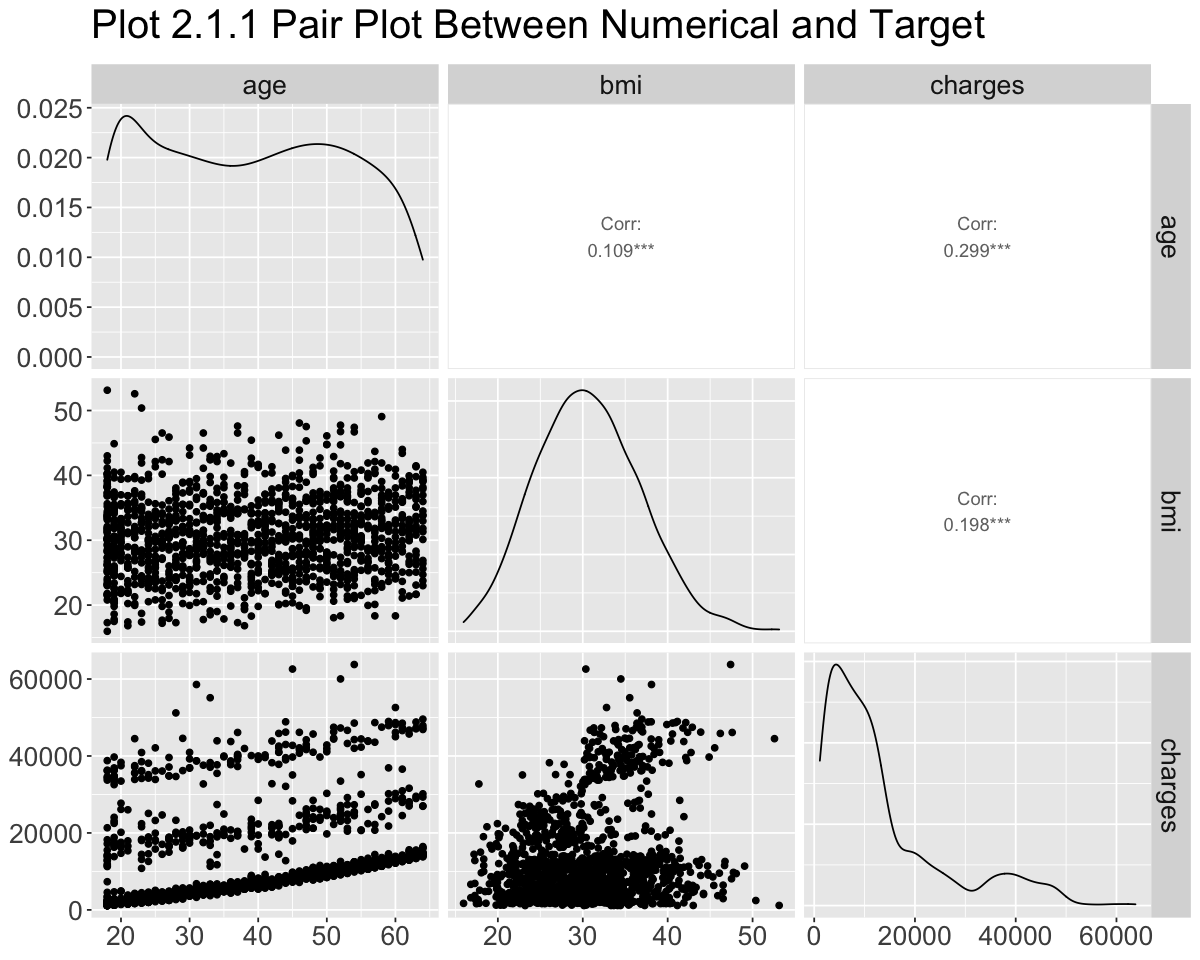

In [80]:
options(repr.plot.width = 10, repr.plot.height = 8)
contunuous_variable<- data%>%select('age','bmi','charges')%>%as.data.frame() 
# contunuous_variable
data_pair_plots_continuous  <- contunuous_variable%>%
  ggpairs() +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
  ggtitle(expression("Plot 2.1.1 Pair Plot Between Numerical and Target"))

data_pair_plots_continuous 

All variables are positively correlated. <br>
`age` and `charges` has the highest correlation score ($0.299$).<br>
`bmi` and `charges` has the second highest correlation score ($0.198$).<br>
`age` and `bmi` has the lowest correlation score ($0.109$).<br><br>
We can also see that charges vs age has three groups (layers), <br >and bmi vs charges has two clusters. <br>
We will dive more about this during the analysis phase later.

In [84]:
# heatmap
corr_matrix_data <- data %>%ungroup() %>%
select('age','bmi','charges') %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")
corr_matrix_data 

var1,var2,corr
<chr>,<chr>,<dbl>
age,age,1.0000000
age,bmi,0.1092719
age,charges,0.2990082
bmi,age,0.1092719
bmi,bmi,1.0000000
bmi,charges,0.1983410
charges,age,0.2990082
charges,bmi,0.1983410
charges,charges,1.0000000


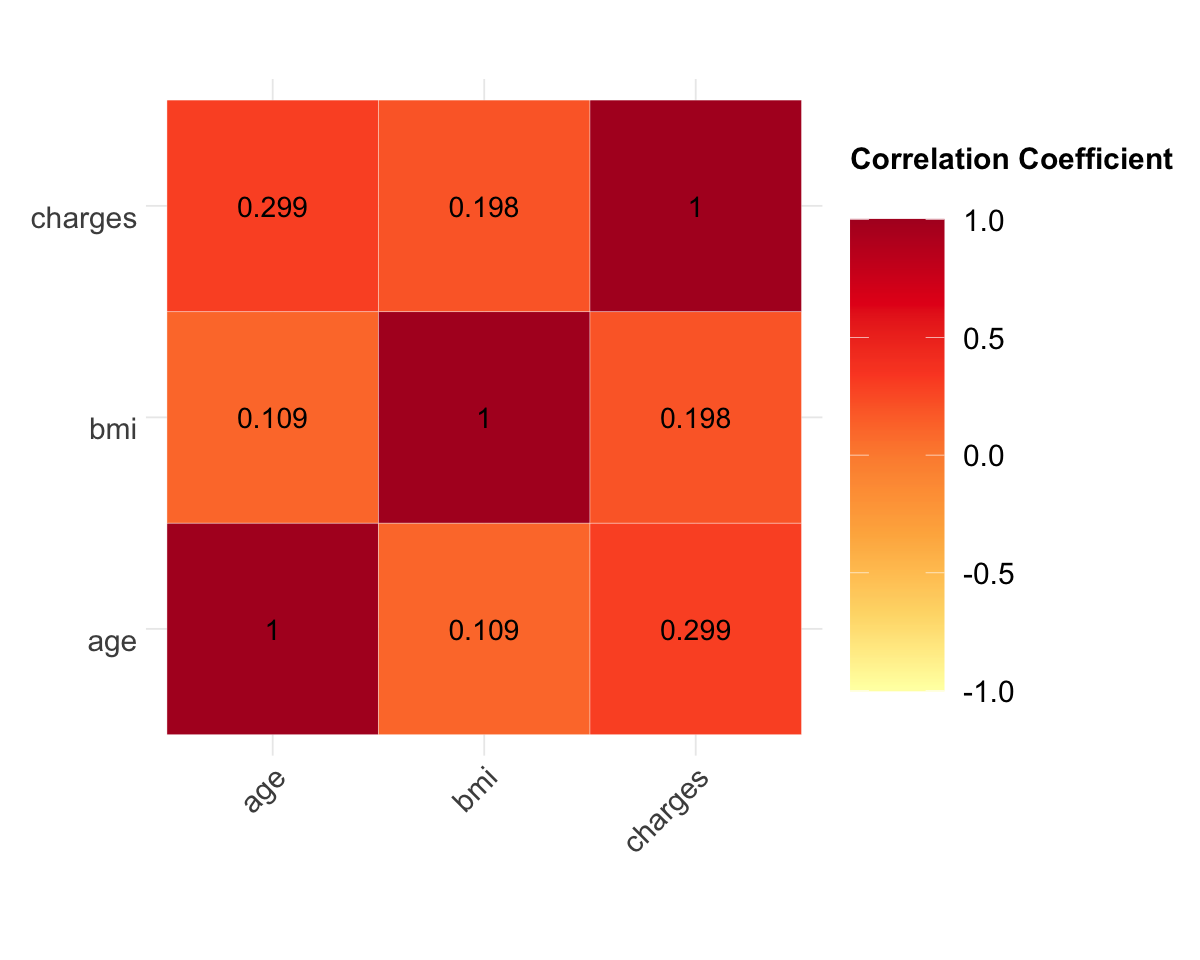

In [85]:
plot_corr_matrix_data <- corr_matrix_data %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette = "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var2, var1, label = round(corr, 3)), color = "black", size = 6)
plot_corr_matrix_data

**As for correlation between categorical variables and target, we decide to do box plots**

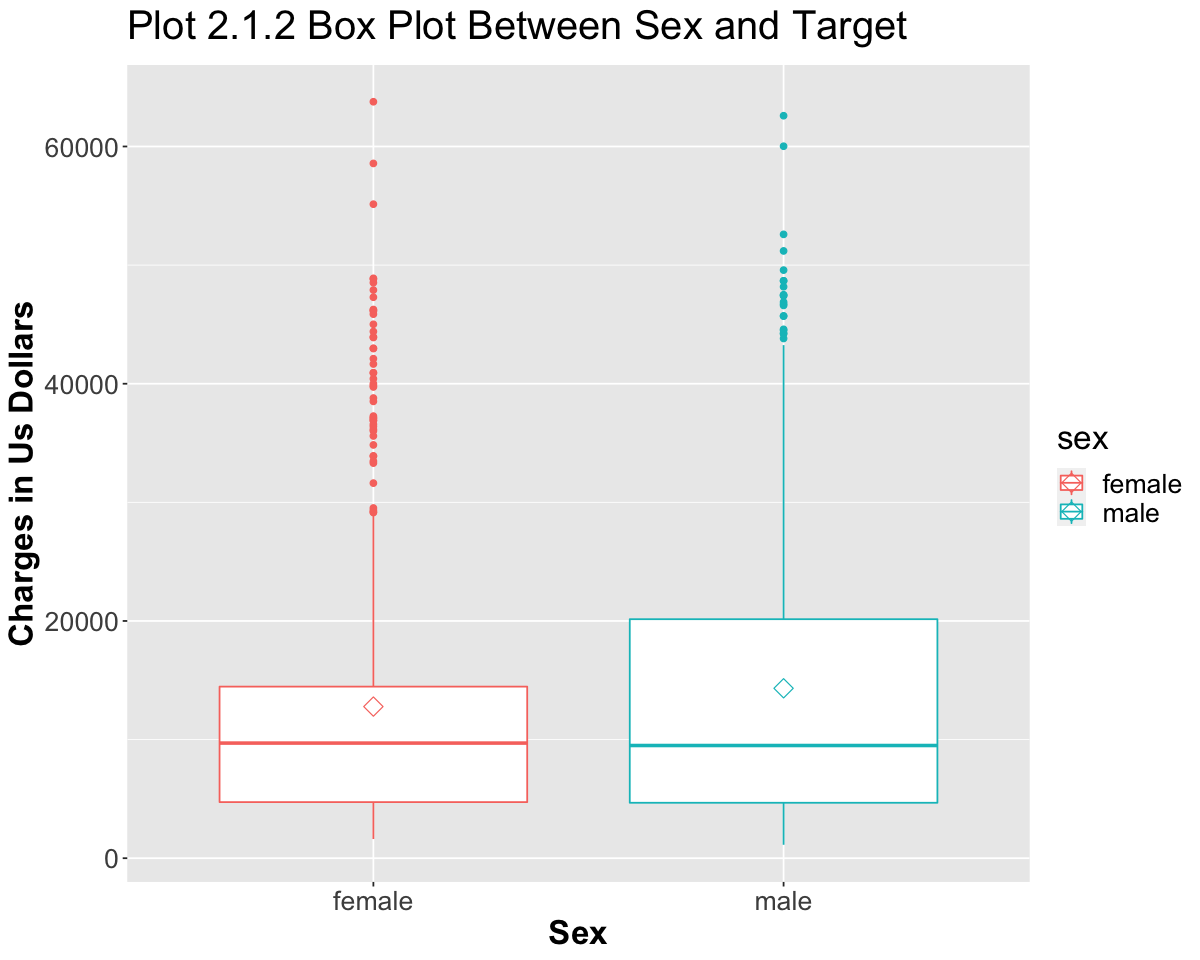

In [108]:
#"sex", "children", "smoker", "region"
options(repr.plot.width = 10, repr.plot.height = 8)

box_sex <- ggplot(training_set, aes(x=sex, y=charges,color=sex)) + 
  geom_boxplot()+ stat_summary(fun=mean, geom="point", shape=23, size=4)+
    ylab("Charges in Us Dollars") +
      xlab("Sex") +
    theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
  ggtitle(expression("Plot 2.1.2 Box Plot Between Sex and Target"))

box_sex

From the plot above, the median of both genders are roughly the same. <br> 
However, the mean of charges of male is slighter higher than female, with less outliers<br>

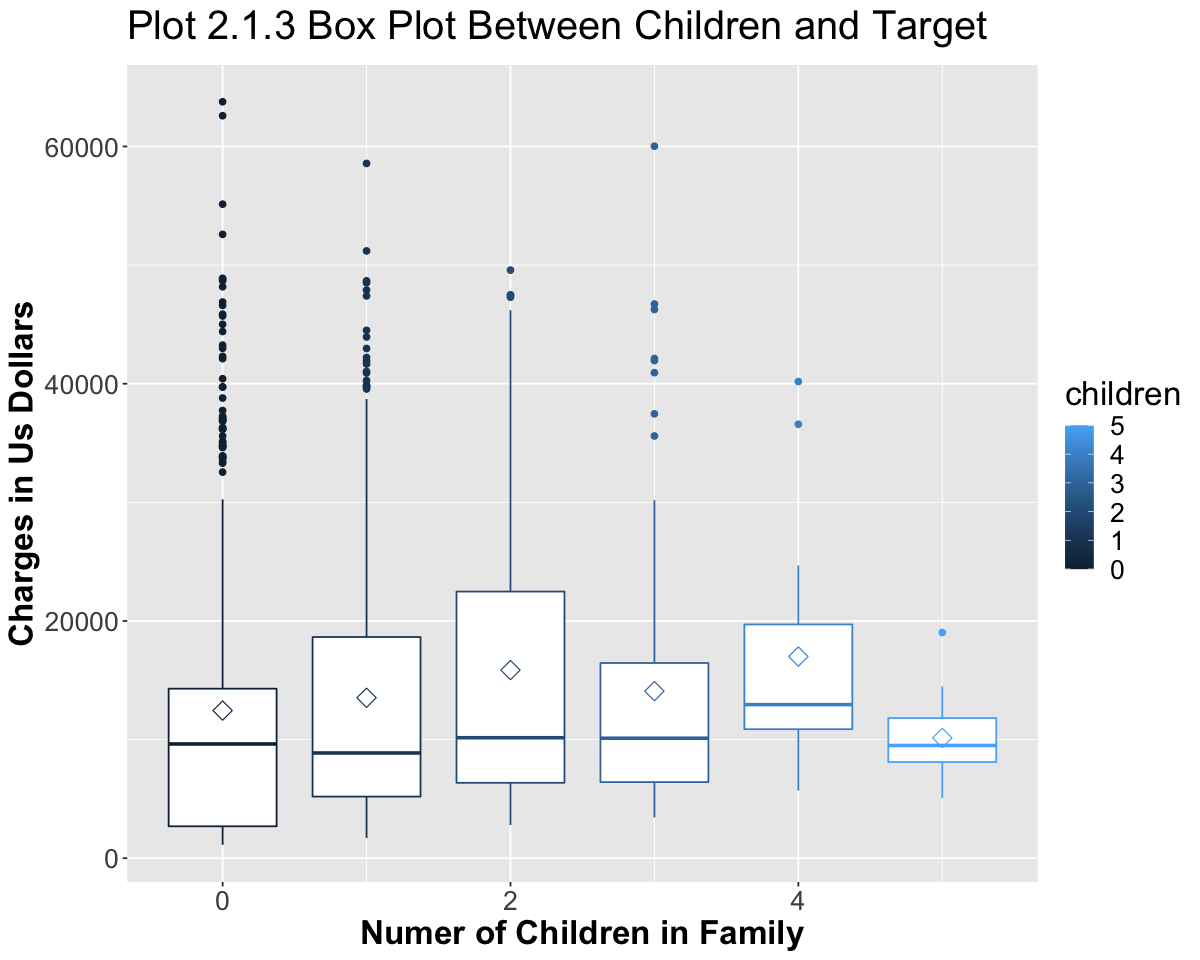

In [109]:
# "children", "smoker", "region"
options(repr.plot.width = 10, repr.plot.height = 8)

box_children <- ggplot(training_set, aes(x=children, y=charges,color=children, group=children)) + 
  geom_boxplot()+ stat_summary(fun=mean, geom="point", shape=23, size=4)+
    ylab("Charges in Us Dollars") +
      xlab("Numer of Children in Family") +
    theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
  ggtitle(expression("Plot 2.1.3 Box Plot Between Children and Target"))

box_children

From the above graph, the mean of families with 4 children has the highest median, the rest groups have similar medians <br>
It seems the Q3 (75th percentile observation) of familie with 2 children is higher than the Q3 on all the rest of the family.<br>
It can be inferred that family who are paying more than $20000 are more likely to be the families with 2 children.

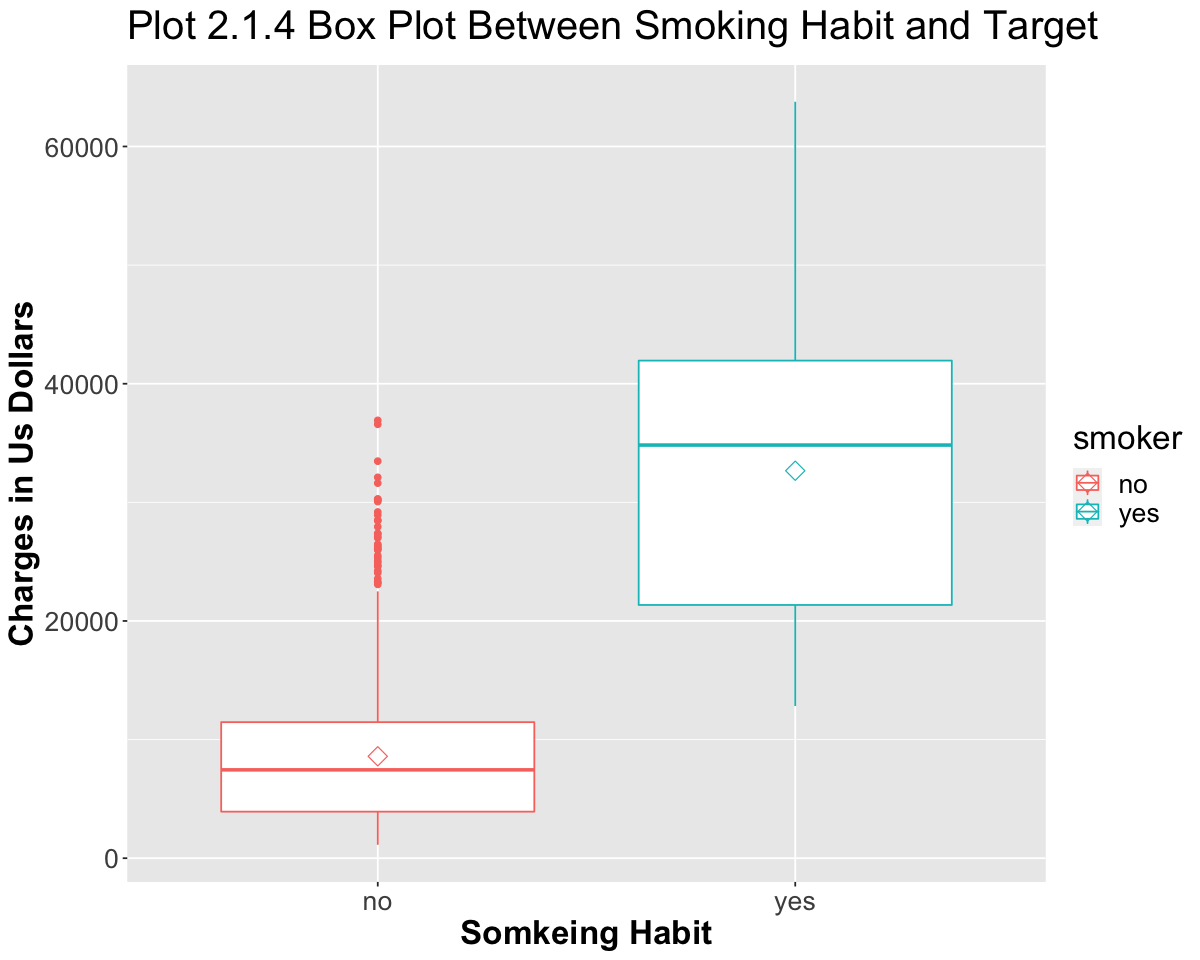

In [110]:
#  "region"
options(repr.plot.width = 10, repr.plot.height = 8)

box_smoker <- ggplot(training_set, aes(x=smoker, y=charges,color=smoker)) + 
  geom_boxplot()+ stat_summary(fun=mean, geom="point", shape=23, size=4)+
    ylab("Charges in Us Dollars") +
      xlab("Somkeing Habit") +
    theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
    ggtitle(expression("Plot 2.1.4 Box Plot Between Smoking Habit and Target"))

box_smoker

From the plot above, it is obvious that smokers pay more than non-smokers

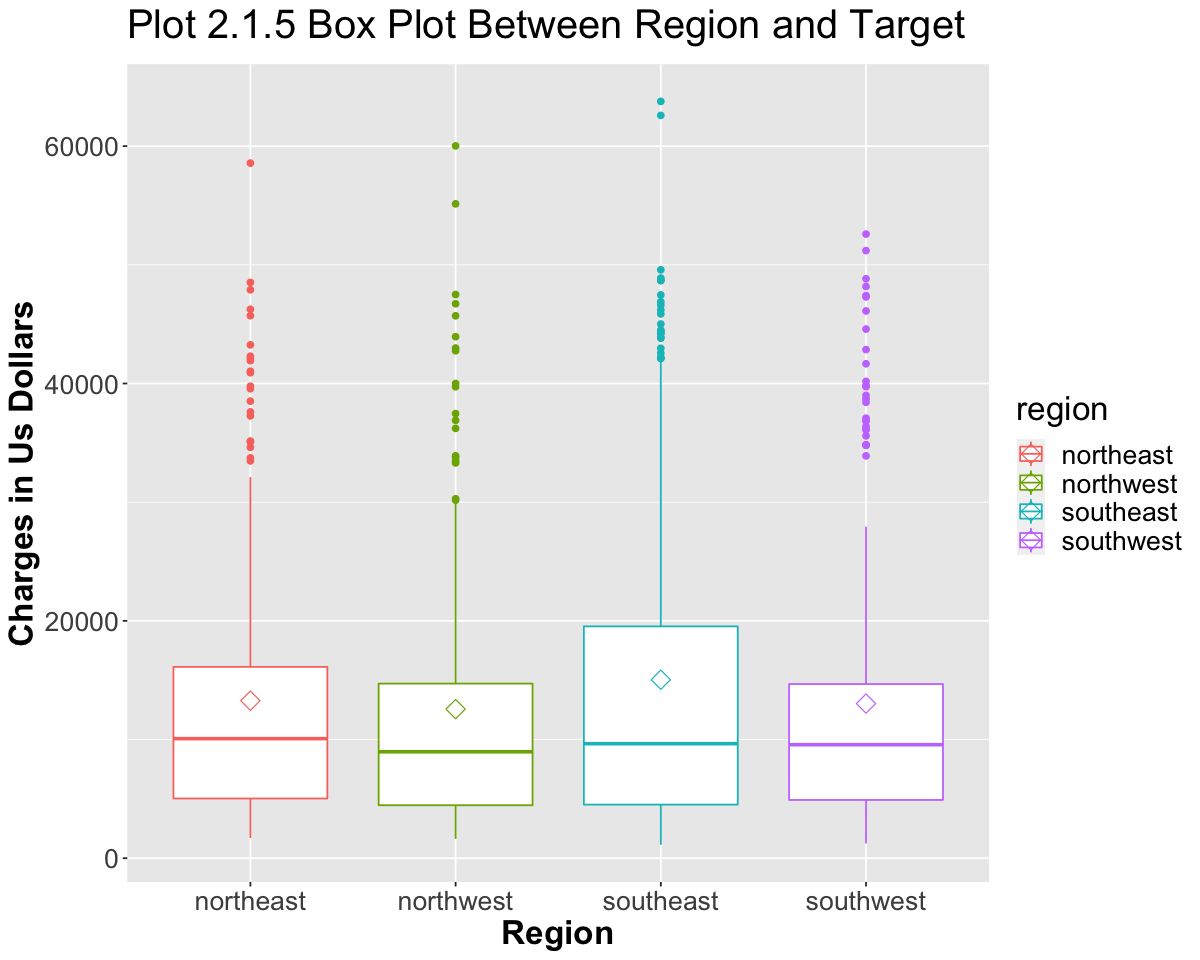

In [111]:
options(repr.plot.width = 10, repr.plot.height = 8)

box_region <- ggplot(training_set, aes(x=region, y=charges,color=region, group=region)) + 
  geom_boxplot()+ stat_summary(fun=mean, geom="point", shape=23, size=4)+
    ylab("Charges in Us Dollars") +
      xlab("Region") +
    theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
    ggtitle(expression("Plot 2.1.5 Box Plot Between Region and Target"))

box_region

From the above graph, the mean of families from all regions have similar median <br>
It seems the Q3 (75th percentile observation) of region Southeast is higher than the Q3 on all the rest of the regions,
but still below 20000 dollars.<br>
It can be inferred that most of families paying no more than $20000 regardless of the regions. 

**Performing a multiple linear regression by using all the variables**

In [118]:
MLR <- lm(formula = charges ~ ., data = training_set[-8])

MLR_results <- tidy(MLR) %>% mutate_if(is.numeric, round, 2)
MLR_results

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-11833.41,1214.17,-9.75,0.00
age,253.81,14.79,17.16,0.00
sexmale,-128.42,415.47,-0.31,0.76
bmi,348.28,35.61,9.78,0.00
children,519.88,176.79,2.94,0.00
smokeryes,24339.40,513.56,47.39,0.00
regionnorthwest,-207.85,597.89,-0.35,0.73
regionsoutheast,-1671.78,596.30,-2.80,0.01
regionsouthwest,-1042.73,595.11,-1.75,0.08


By using critical value = $0.05$, we can see that most of the variables are significant but `sexmale` and `regionnorthwest`.<br>
It can be inferred that these two features might not be helpful in the inference and prediction phase.

**Performing a multicollinearity check by using GVIF**<br>
GVIF is the square root of the VIF for individual predictors and thus can be used equivalently (FAQ/Collinearity - CBU Statistics Wiki, 2015).<br>
Reference: <br>
FAQ/Collinearity - CBU statistics Wiki. (2015, January). CBU Statistics Wiki. https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/Collinearity

In [119]:
VIF_MLR_data<- vif(MLR)
round(VIF_MLR_data, 3)

,GVIF,Df,GVIF^(1/(2*Df))
age,1.020,1,1.010
sex,1.014,1,1.007
bmi,1.162,1,1.078
children,1.013,1,1.006
smoker,1.015,1,1.007
region,1.157,3,1.025


<p style="text-align: center;"> *Table $2.1.2$ VIF Result*

All GVIF values are rather moderate (around 1)<br> This is not an indication of multicollinearity.

**Performing a confounding check by using F test**

In [124]:
summary(aov(MLR))

             Df    Sum Sq   Mean Sq  F value   Pr(>F)    
age           1 1.117e+10 1.117e+10  280.459  < 2e-16 ***
sex           1 5.974e+08 5.974e+08   14.999 0.000115 ***
bmi           1 4.894e+09 4.894e+09  122.872  < 2e-16 ***
children      1 4.089e+08 4.089e+08   10.266 0.001401 ** 
smoker        1 8.927e+10 8.927e+10 2241.412  < 2e-16 ***
region        3 3.850e+08 1.283e+08    3.222 0.022078 *  
Residuals   927 3.692e+10 3.983e+07                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

<p style="text-align: center;"> *Table $2.1.3$ ANOVA Result*

By using p values as a criterion for the identification of confounders.<br>
By using a significance level of 0.05, since there is no p-value greater than 0.05,<br>
we can conclude that there is no obvious confounder in the model above. 

#### Visualizing the association between variables in dataset

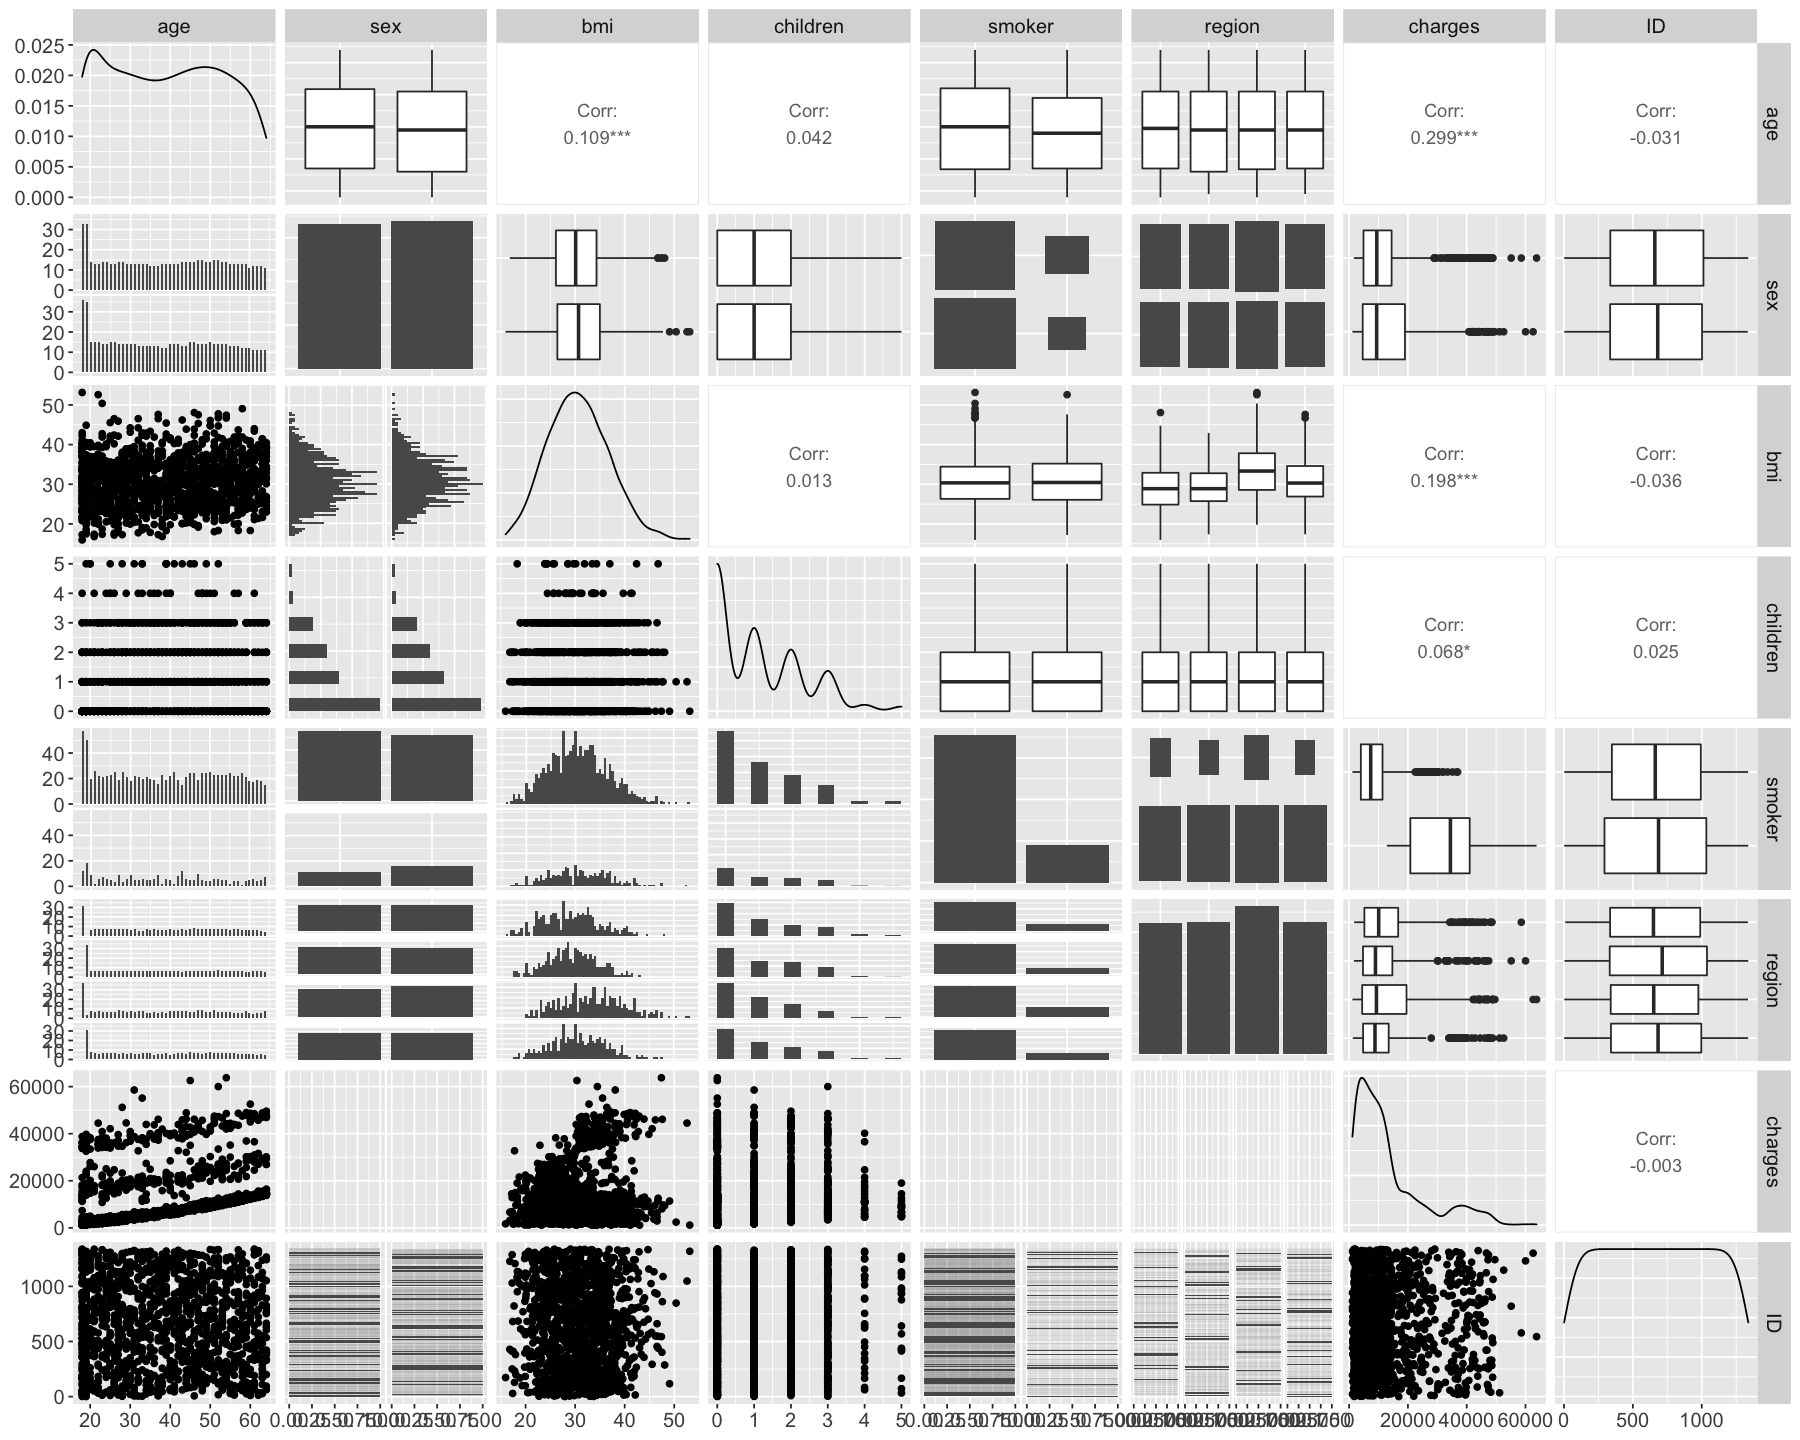

In [68]:
# options(repr.plot.width = 15, repr.plot.height = 12)

# data_pair_plots <- data %>%
#   ggpairs(lower = list(combo = wrap(ggally_facethist, binwidth = 0.5))) +
#   theme(
#     text = element_text(size = 15),
#     plot.title = element_text(face = "bold"),
#     axis.title = element_text(face = "bold"))
# data_pair_plots

Based on the pairwise plots and correlation coefficients in data_pair_plots,<br>
There has no obvious multicolinearly variables


### Check for Confounding

In [19]:
summary(MLR)


Call:
lm(formula = charges ~ ., data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-11304.9  -2848.1   -982.1   1393.9  29992.8 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11938.5      987.8 -12.086  < 2e-16 ***
age                256.9       11.9  21.587  < 2e-16 ***
sexmale           -131.3      332.9  -0.394 0.693348    
bmi                339.2       28.6  11.860  < 2e-16 ***
children           475.5      137.8   3.451 0.000577 ***
smokeryes        23848.5      413.1  57.723  < 2e-16 ***
regionnorthwest   -353.0      476.3  -0.741 0.458769    
regionsoutheast  -1035.0      478.7  -2.162 0.030782 *  
regionsouthwest   -960.0      477.9  -2.009 0.044765 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6062 on 1329 degrees of freedom
Multiple R-squared:  0.7509,	Adjusted R-squared:  0.7494 
F-statistic: 500.8 on 8 and 1329 DF,  p-value: < 2.2e-16


In [20]:
aov(MLR)

Call:
   aov(formula = MLR)

Terms:
                         age          sex          bmi     children
Sum of Squares   17530192183    791665482   5257642817    551112172
Deg. of Freedom            1            1            1            1
                      smoker       region    Residuals
Sum of Squares  122870644862    233431209  48839532844
Deg. of Freedom            1            3         1329

Residual standard error: 6062.102
Estimated effects may be unbalanced